# GAF + LMDB + PyTorch Model Training Notebook
This notebook:
- Converts tabular network flows to GAF images (with GPU acceleration)
- Stores GAF images and labels in LMDB
- Loads data into PyTorch DataLoader
- Trains a CNN on the data
- Evaluates model and prints analysis

In [9]:

import os
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import torch
import matplotlib.pyplot as plt
import io
import lmdb
import pickle
import gc


In [10]:

# ==== Set these ====
input_folder = './data'
output_folder = './output/'
lmdb_path = os.path.join(output_folder, 'gaf_images')
pca_components = 32
os.makedirs(output_folder, exist_ok=True)


In [11]:

def gaf_transform_torch(x, device='cpu'):
    min_x = x.min(dim=1, keepdim=True).values
    max_x = x.max(dim=1, keepdim=True).values
    scaled_x = (2 * (x - min_x) / (max_x - min_x + 1e-8)) - 1
    scaled_x = torch.clamp(scaled_x, -1, 1)
    phi = torch.arccos(scaled_x)
    gaf = torch.cos(phi.unsqueeze(2) + phi.unsqueeze(1))
    return gaf


In [12]:

if torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA:", torch.cuda.get_device_name(0))
elif getattr(torch.backends, 'mps', None) and torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple MPS (Metal Performance Shaders)")
else:
    device = torch.device('cpu')
    print("Using CPU")


Using CUDA: NVIDIA GeForce RTX 3070 Laptop GPU


In [13]:

dos_attacks = ['DoS GoldenEye', 'DoS Hulk', 'DoS Slowhttptest', 'DoS slowloris']
brute_force_attacks = ['FTP-Patator', 'SSH-Patator']
web_attacks = ['Web Attack � Brute Force', 'Web Attack � Sql Injection', 'Web Attack � XSS']

def map_to_broader_category(label):
    if label == 'BENIGN':
        return 'BENIGN'
    elif label == 'DDoS':
        return 'DDoS'
    elif label == 'PortScan':
        return 'PortScan'
    elif label in dos_attacks:
        return 'DoS'
    elif label in brute_force_attacks:
        return 'BruteForce'
    elif label in web_attacks:
        return 'WebAttack'
    elif label == 'Bot':
        return 'Bot'
    elif label == 'Infiltration':
        return 'Infiltration'
    elif label == 'Heartbleed':
        return 'Heartbleed'
    else:
        return 'Other'


In [14]:
checkpoint_folder = os.path.join(output_folder, 'checkpoints')
os.makedirs(checkpoint_folder, exist_ok=True)

# Use a more reasonable map_size (e.g. 10GB)
env = lmdb.open(lmdb_path, map_size=50 * 1024 ** 3)
csv_files = [f for f in os.listdir(input_folder) if f.endswith('.csv')]
scaler = StandardScaler()
pca = PCA(n_components=pca_components)

with env.begin(write=True) as txn:
    for csv_file in csv_files:
        # Check if CSV already done
        checkpoint_file = os.path.join(checkpoint_folder, csv_file + '.done')
        if os.path.exists(checkpoint_file):
            print(f"✅ Skipping {csv_file} (already processed, found checkpoint)")
            continue

        print(f"\n📄 Processing {csv_file}...")
        try:
            df_path = os.path.join(input_folder, csv_file)
            df = pd.read_csv(df_path)
            df.columns = df.columns.str.strip()
            if 'Label' not in df.columns:
                print(f"⚠️ Skipping {csv_file} — 'Label' column not found.")
                continue

            df = df.replace([np.inf, -np.inf], np.nan).dropna()
            labels = df['Label'].values
            features = df.select_dtypes(include=[np.number])
            features = features.replace([np.inf, -np.inf], np.nan).dropna()
            X = features.values
            y = labels

            unique_classes = np.unique(y)
            if len(unique_classes) > 1:
                print(f"Before SMOTE: {dict(zip(*np.unique(y, return_counts=True)))}")
                smote = SMOTE(random_state=42)
                X_res, y_res = smote.fit_resample(X, y)
                print(f"After SMOTE: {dict(zip(*np.unique(y_res, return_counts=True)))}")

                # Undersampling
                rus = RandomUnderSampler(sampling_strategy='auto', random_state=42)
                X_res, y_res = rus.fit_resample(X_res, y_res)
                print(f"After undersampling: {dict(zip(*np.unique(y_res, return_counts=True)))}")
            else:
                print(f"Skipping SMOTE for {csv_file} — only found one class: {unique_classes[0]}")
                X_res, y_res = X, y

            y_categorized = np.array([map_to_broader_category(label) for label in y_res])
            print(f"After category merging: {dict(zip(*np.unique(y_categorized, return_counts=True)))}")
            y_res = y_categorized

            features_scaled = scaler.fit_transform(X_res)
            features_reduced = pca.fit_transform(features_scaled)
            labels_res = y_res

            print(f"Generating GAF images and storing (label, data) in LMDB...")

            # ✅ BATCHED GAF PROCESSING TO PREVENT OOM
            batch_size = 1024
            for start_idx in range(0, len(features_reduced), batch_size):
                end_idx = min(start_idx + batch_size, len(features_reduced))
                batch_features = features_reduced[start_idx:end_idx]
                batch_labels = labels_res[start_idx:end_idx]

                try:
                    flows_torch = torch.tensor(batch_features, dtype=torch.float32, device=device)
                    gaf_images = gaf_transform_torch(flows_torch, device=device).cpu().numpy()

                    for idx, (gaf_image, label) in enumerate(zip(gaf_images, batch_labels)):
                        buf = io.BytesIO()
                        plt.imsave(buf, gaf_image, cmap='gray', format='png')
                        buf.seek(0)
                        image_bytes = buf.read()
                        buf.close()
                        key = f"{os.path.splitext(csv_file)[0]}_{start_idx + idx:07d}".encode('utf-8')
                        record = {"label": str(label), "data": image_bytes}
                        txn.put(key, pickle.dumps(record))
                except Exception as e:
                    print(f"⚠️ Error on batch {start_idx}-{end_idx}: {e}")
                    continue

                torch.cuda.empty_cache()
                gc.collect()

            # === Write checkpoint file to mark as done ===
            with open(checkpoint_file, 'w') as f:
                f.write('done')
            print(f"Checkpoint saved: {checkpoint_file}")
        except Exception as e:
            print(f"❌ Error processing {csv_file}: {e}")
            continue

print("\n✅ GAF image generation and LMDB (label, data) storage complete.")


✅ Skipping Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv (already processed, found checkpoint)
✅ Skipping Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv (already processed, found checkpoint)
✅ Skipping Friday-WorkingHours-Morning.pcap_ISCX.csv (already processed, found checkpoint)
✅ Skipping Monday-WorkingHours.pcap_ISCX.csv (already processed, found checkpoint)
✅ Skipping Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv (already processed, found checkpoint)
✅ Skipping Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv (already processed, found checkpoint)
✅ Skipping Tuesday-WorkingHours.pcap_ISCX.csv (already processed, found checkpoint)

📄 Processing Wednesday-workingHours.pcap_ISCX.csv...
Before SMOTE: {'BENIGN': np.int64(439683), 'DoS GoldenEye': np.int64(10293), 'DoS Hulk': np.int64(230124), 'DoS Slowhttptest': np.int64(5499), 'DoS slowloris': np.int64(5796), 'Heartbleed': np.int64(11)}
After SMOTE: {'BENIGN': np.int64(439683), 'DoS GoldenEye': np.int64(439

## Load LMDB as PyTorch Dataset

In [15]:

from torch.utils.data import Dataset
import torchvision.transforms as T
from PIL import Image

class LMDBGAFDataset(Dataset):
    def __init__(self, lmdb_path, transform=None):
        self.env = lmdb.open(lmdb_path, readonly=True, lock=False)
        self.txn = self.env.begin()
        self.keys = []
        self.labels = []
        self.transform = transform
        with self.env.begin() as txn:
            for key, value in txn.cursor():
                record = pickle.loads(value)
                label = record['label']
                self.keys.append(key)
                self.labels.append(label)
        self.label_to_idx = {lbl: idx for idx, lbl in enumerate(sorted(set(self.labels)))}
    def __len__(self):
        return len(self.keys)
    def __getitem__(self, idx):
        key = self.keys[idx]
        value = self.txn.get(key)
        record = pickle.loads(value)
        label = record['label']
        image = Image.open(io.BytesIO(record['data'])).convert('L')
        if self.transform:
            image = self.transform(image)
        label_idx = self.label_to_idx[label]
        return image, label_idx


In [25]:

from torch.utils.data import random_split, DataLoader

transform = T.Compose([
    T.ToTensor(),
    T.Normalize([0.5], [0.5])
])

lmdb_path = os.path.join(output_folder, 'gaf_images')
dataset = LMDBGAFDataset(lmdb_path, transform=transform)

n = len(dataset)
n_train = int(0.7 * n)
n_val = int(0.15 * n)
n_test = n - n_train - n_val
train_set, val_set, test_set = random_split(dataset, [n_train, n_val, n_test])

batch_size = 64
# Set num_workers=0 in all DataLoaders
train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)

num_classes = len(dataset.label_to_idx)
print("Classes:", dataset.label_to_idx)


Classes: {'BENIGN': 0, 'BruteForce': 1, 'DoS': 2, 'Heartbleed': 3, 'Infiltration': 4, 'WebAttack': 5}


In [26]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision.models import ResNet18_Weights, MobileNet_V2_Weights

# --- Option to select model type ---
model_type = "mobilenetv2"  # options: 'simple', 'resnet18', 'mobilenetv2'
print("Model type:", model_type)

input_size = dataset[0][0].shape[-1]

if model_type == "simple":
    class SimpleGAFNet(nn.Module):
        def __init__(self, num_classes, input_size=32):
            super().__init__()
            self.conv1 = nn.Conv2d(1, 16, 3, padding=1)
            self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
            self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
            self.pool = nn.MaxPool2d(2, 2)
            self.flatten_size = (input_size // 8) * (input_size // 8) * 64
            self.fc1 = nn.Linear(self.flatten_size, 128)
            self.fc2 = nn.Linear(128, num_classes)

        def forward(self, x):
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            x = x.view(x.size(0), -1)
            x = F.relu(self.fc1(x))
            return self.fc2(x)

    model = SimpleGAFNet(num_classes=num_classes, input_size=input_size)

elif model_type == "resnet18":
    model = models.resnet18(weights=None)  # 🔧 use weights=None instead of pretrained=False
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    model.fc = nn.Linear(model.fc.in_features, num_classes)

elif model_type == "mobilenetv2":
    model = models.mobilenet_v2(weights=None)  # 🔧 use weights=None instead of pretrained=False
    model.features[0][0] = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

else:
    raise ValueError("Unknown model_type")

model = model.to(device)
print("Model ready:", model_type)



Model type: mobilenetv2
Model ready: mobilenetv2


In [27]:

import torch.optim as optim

optimizer = optim.Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

def train_one_epoch(model, loader, optimizer, criterion, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        optimizer.zero_grad()
        out = model(imgs)
        loss = criterion(out, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        _, preds = out.max(1)
        correct += (preds == labels).sum().item()
        total += imgs.size(0)
    return total_loss / total, correct / total

def evaluate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for imgs, labels in loader:
            imgs, labels = imgs.to(device), labels.to(device)
            out = model(imgs)
            loss = criterion(out, labels)
            total_loss += loss.item() * imgs.size(0)
            _, preds = out.max(1)
            correct += (preds == labels).sum().item()
            total += imgs.size(0)
    return total_loss / total, correct / total

for epoch in range(1, 11):  # 10 epochs
    train_loss, train_acc = train_one_epoch(model, train_loader, optimizer, criterion, device)
    val_loss, val_acc = evaluate(model, val_loader, criterion, device)
    print(f"Epoch {epoch}: Train loss {train_loss:.4f}, acc {train_acc:.3f} | Val loss {val_loss:.4f}, acc {val_acc:.3f}")

test_loss, test_acc = evaluate(model, test_loader, criterion, device)
print(f"\nTest loss: {test_loss:.4f}, accuracy: {test_acc:.3f}")


Epoch 1: Train loss 0.0249, acc 0.993 | Val loss 0.0119, acc 0.997
Epoch 2: Train loss 0.0111, acc 0.997 | Val loss 0.0081, acc 0.997
Epoch 3: Train loss 0.0088, acc 0.997 | Val loss 0.0077, acc 0.998
Epoch 4: Train loss 0.0076, acc 0.998 | Val loss 0.0075, acc 0.998
Epoch 5: Train loss 0.0068, acc 0.998 | Val loss 0.0055, acc 0.998
Epoch 6: Train loss 0.0062, acc 0.998 | Val loss 0.0050, acc 0.999
Epoch 7: Train loss 0.0058, acc 0.998 | Val loss 0.0047, acc 0.999
Epoch 8: Train loss 0.0056, acc 0.998 | Val loss 0.0050, acc 0.999
Epoch 9: Train loss 0.0054, acc 0.998 | Val loss 0.0044, acc 0.999
Epoch 10: Train loss 0.0051, acc 0.999 | Val loss 0.0049, acc 0.998

Test loss: 0.0049, accuracy: 0.999


## Model Analysis: Confusion Matrix and Classification Report

In [28]:

from sklearn.metrics import confusion_matrix, classification_report
import numpy as np

model.eval()
all_labels = []
all_preds = []

with torch.no_grad():
    for imgs, labels in test_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        out = model(imgs)
        _, preds = out.max(1)
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds.cpu().numpy())

print("Classification report:")
print(classification_report(all_labels, all_preds, target_names=dataset.label_to_idx.keys()))
cm = confusion_matrix(all_labels, all_preds)
print("Confusion matrix:\n", cm)


Classification report:
              precision    recall  f1-score   support

      BENIGN       1.00      1.00      1.00    278674
  BruteForce       1.00      1.00      1.00    129574
         DoS       1.00      1.00      1.00    264039
  Heartbleed       1.00      1.00      1.00     65707
Infiltration       1.00      1.00      1.00     43314
   WebAttack       1.00      1.00      1.00     75484

    accuracy                           1.00    856792
   macro avg       1.00      1.00      1.00    856792
weighted avg       1.00      1.00      1.00    856792

Confusion matrix:
 [[277676     55    828      0      1    114]
 [    85 129489      0      0      0      0]
 [    91      0 263948      0      0      0]
 [     0      0      0  65707      0      0]
 [    96      0      0      0  43218      0]
 [     8      0      0      0      0  75476]]


Generating advanced metrics...


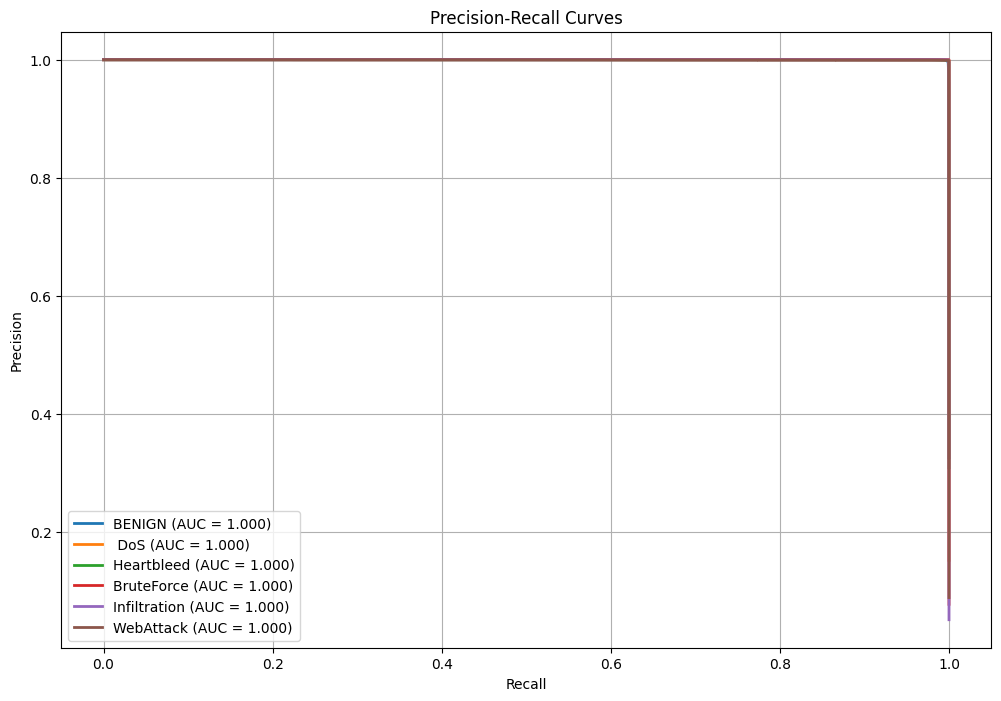

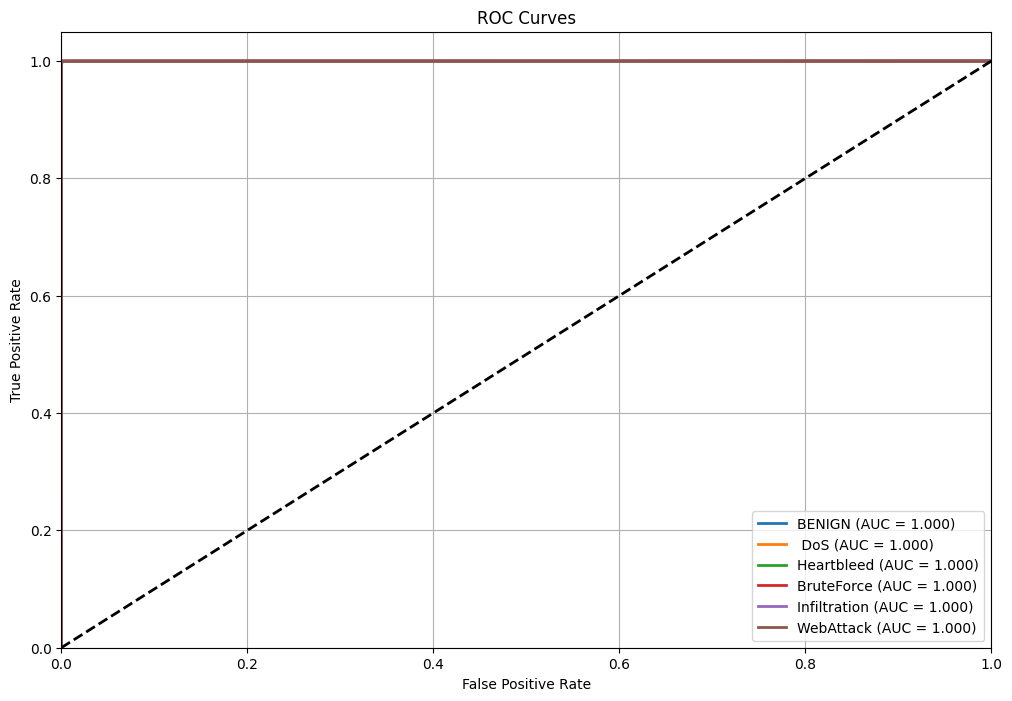

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, roc_curve, auc

# Advanced metrics visualization
def plot_precision_recall_curves(y_true, y_pred_proba, classes):
    '''Plot precision-recall curve for each class'''
    plt.figure(figsize=(12, 8))
    
    # For each class
    for i, cls in enumerate(classes):
        # Binarize the output
        y_true_bin = (y_true == i).astype(int)
        
        # Get prediction probability for this class
        y_pred_proba_cls = y_pred_proba[:, i]
        
        # Calculate precision and recall
        precision, recall, _ = precision_recall_curve(y_true_bin, y_pred_proba_cls)
        
        # Calculate area under PR curve
        pr_auc = auc(recall, precision)
        
        # Plot PR curve
        plt.plot(recall, precision, lw=2, label=f'{cls} (AUC = {pr_auc:.3f})')
    
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend(loc='best')
    plt.grid(True)
    plt.savefig('precision_recall_curves.png')
    plt.show()

def plot_roc_curves(y_true, y_pred_proba, classes):
    '''Plot ROC curve for each class'''
    plt.figure(figsize=(12, 8))
    
    # For each class
    for i, cls in enumerate(classes):
        # Binarize the output
        y_true_bin = (y_true == i).astype(int)
        
        # Get prediction probability for this class
        y_pred_proba_cls = y_pred_proba[:, i]
        
        # Calculate ROC curve
        fpr, tpr, _ = roc_curve(y_true_bin, y_pred_proba_cls)
        
        # Calculate area under ROC curve
        roc_auc = auc(fpr, tpr)
        
        # Plot ROC curve
        plt.plot(fpr, tpr, lw=2, label=f'{cls} (AUC = {roc_auc:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.savefig('roc_curves.png')
    plt.show()

# After model evaluation, add these lines:
print("Generating advanced metrics...")
# Get class probabilities on test data
model.eval()
test_probs = []
test_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        probs = torch.nn.functional.softmax(outputs, dim=1)
        test_probs.append(probs.cpu().numpy())
        test_labels.append(labels.numpy())

# Concatenate batches
test_probs = np.concatenate(test_probs)
test_labels = np.concatenate(test_labels)

# Plot precision-recall and ROC curves
class_names = ['BENIGN', ' DoS', 'Heartbleed', 'BruteForce', 'Infiltration', 'WebAttack']
plot_precision_recall_curves(test_labels, test_probs, class_names)
plot_roc_curves(test_labels, test_probs, class_names)